# Tensorflow Road Signs YOLO Debugging Notebook

## Setup

In [1]:
# Import packages from the Python standard library
import warnings
from pathlib import Path

# Please enter custom username here.
USERNAME = "jglasbrenner"

# Filter out warning messages
warnings.filterwarnings("ignore")

# Experiment name (note the username_ prefix convention)
EXPERIMENT_NAME = f"{USERNAME}_roadsigns_yolo"

# Import third-party Python packages
import cloudpickle
import imgaug as ia
import numpy as np
import tensorflow as tf
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from mitre.securingai import pyplugs
from mitre.securingai.sdk.utilities.contexts import plugin_dirs

# Import utils.py file
import utils

# Create random number generator
rng = np.random.default_rng(54399264723942495723666216079516778448)

In [2]:
DATA_DIR = Path("data")
MODELS_DIR = Path("models")
ROADSIGNS_TRAINING_DIR = DATA_DIR / "roadsigns" / "training"
ROADSIGNS_TESTING_DIR = DATA_DIR / "roadsigns" / "testing"
SPEED_LIMIT_TRAINING_DIR = DATA_DIR / "speedlimit" / "training"
SPEED_LIMIT_EVALUATION_DIR = DATA_DIR / "speedlimit" / "evaluation"
SPEED_LIMIT_TESTING_DIR = DATA_DIR / "speedlimit" / "testing"
YOLO_MOBILENETV2_MODEL_DIR = MODELS_DIR / "roadsigns_yolo_mobilenetv2_yolo" / "1"

PREDICTIONS_DIR = Path("object_detection_predictions")
PREDICTIONS_NPY = PREDICTIONS_DIR / "predictions.npy"

CUSTOM_OBJECTS_PKL = YOLO_MOBILENETV2_MODEL_DIR / "custom_objects.cloudpickle"
YOLO_MOBILENETV2 = YOLO_MOBILENETV2_MODEL_DIR / "model"

In [3]:
with plugin_dirs(["task-plugins"]):
    from securingai_custom.roadsigns_yolo_estimators import data as data_module
    from securingai_custom.roadsigns_yolo_estimators import keras_object_detectors, losses

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.image import combined_non_max_suppression

In [5]:
model = keras_object_detectors.init_object_detector("mobilenetv2", Adam(), 1)

2022-01-26 18:36:22.072413: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-26 18:36:22.072635: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
training_ds, n_classes = data_module.create_object_detection_dataset(
    root_directory=SPEED_LIMIT_TRAINING_DIR,
    image_size=(448, 448, 3),
    seed=80823,
    batch_size=16,
    grid_size=14,
    augment=False,
    shuffle=True,
)
evaluation_ds, n_classes = data_module.create_object_detection_dataset(
    root_directory=SPEED_LIMIT_EVALUATION_DIR,
    image_size=(448, 448, 3),
    batch_size=16,
    grid_size=14,
    augment=False,
    shuffle=False,
)
testing_ds, n_classes = data_module.create_object_detection_dataset(
    root_directory=SPEED_LIMIT_TESTING_DIR,
    image_size=(448, 448, 3),
    batch_size=16,
    grid_size=14,
    augment=False,
    shuffle=False,
)

Found 513 images and 603 bounding boxes belonging to 1 classes.
Found 135 images and 180 bounding boxes belonging to 1 classes.
Found 118 images and 138 bounding boxes belonging to 1 classes.


In [7]:
history = model.fit(training_ds, epochs=2, validation_data=evaluation_ds, verbose=1)

Epoch 1/2


2022-01-26 18:36:45.247568: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


33/33 [==============================] - 72s 2s/step - loss: 33.0254 - val_loss: 40.1243
Epoch 2/2
33/33 [==============================] - 82s 2s/step - loss: 30.1179 - val_loss: 29.2869


In [8]:
# training_sample = list(training_ds.as_numpy_iterator())
testing_sample = list(testing_ds.as_numpy_iterator())
testing_x = [y for x in testing_sample for y in x[0]]
testing_y = [y for x in testing_sample for y in x[1]]

In [9]:
predictions = model.predict(testing_ds)

In [10]:
yolo_loss = losses.YOLOLoss()

def post_process_tensor_output(pred_tensor_output, n_classes, grid_size):
    pred_box_1 = pred_tensor_output[..., 0, :4]
    pred_cfd_1 = tf.keras.activations.sigmoid(pred_tensor_output[..., 0, 4])
    pred_cls_dist_1 = tf.keras.activations.sigmoid(pred_tensor_output[..., 0, 5:])
    pred_box_2 = pred_tensor_output[..., 1, :4]
    pred_cfd_2 = tf.keras.activations.sigmoid(pred_tensor_output[..., 1, 4])
    pred_cls_dist_2 = tf.keras.activations.sigmoid(pred_tensor_output[..., 1, 5:])

    pred_corner_bbox_1 = yolo_loss._convert_cellbox_to_corner_bbox(pred_box_1, (grid_size, grid_size))
    pred_corner_bbox_2 = yolo_loss._convert_cellbox_to_corner_bbox(pred_box_2, (grid_size, grid_size))

    # To use combined_nms() method from TF we must change
    # [x1, y1, x2, y2] to [y1, x1, y2, x2]
    box1 = tf.reshape(
        tf.gather(pred_corner_bbox_1, [1, 0, 3, 2], axis=-1), shape=(-1, grid_size * grid_size, 1, 4)
    )
    box2 = tf.reshape(
        tf.gather(pred_corner_bbox_2, [1, 0, 3, 2], axis=-1), shape=(-1, grid_size * grid_size, 1, 4)
    )
    boxes = tf.concat([box1, box2], axis=1)

    scores1 = tf.reshape(
        tf.expand_dims(pred_cfd_1, axis=-1) * pred_cls_dist_1,
        shape=(-1, grid_size * grid_size, n_classes),
    )
    scores2 = tf.reshape(
        tf.expand_dims(pred_cfd_2, axis=-1) * pred_cls_dist_2,
        shape=(-1, grid_size * grid_size, n_classes),
    )
    scores = tf.concat([scores1, scores2], axis=1)

    boxes, scores, classes, nums = combined_non_max_suppression(
        boxes,
        scores,
        max_output_size_per_class=10,
        max_total_size=49,
        iou_threshold=0.5,
        score_threshold=0.5,
    )

    return boxes, scores, classes, nums



In [11]:
out_boxes, out_scores, out_classes, out_nums = post_process_tensor_output(predictions[0], 1, 14)
in_x = testing_x[0]
in_y = testing_y[0]

In [18]:
out_scores

<tf.Tensor: shape=(1, 49), dtype=float32, numpy=
array([[0.9999982 , 0.999236  , 0.9542802 , 0.8377957 , 0.73706865,
        0.63728815, 0.5581948 , 0.5148206 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]], dtype=float32)>

In [13]:
def show_image_with_bbox(x, y, prediction, n_classes, grid_size, pred_idx):
    boxes, scores, classes, nums = post_process_tensor_output(prediction, n_classes, grid_size)

    train_true_obj = y[..., 4]
    train_bbox_x_idx, train_bbox_y_idx = np.nonzero(train_true_obj)

    train_corner_bboxes = data_module.convert_cellbox_to_corner_bbox_numpy(
        y[..., :4], np.array([grid_size, grid_size], dtype="int32")
    )

    train_img_shape = np.shape(x)[:2]
    true_bbs = BoundingBoxesOnImage(
        [
            BoundingBox(
                x1=train_corner_bboxes[x, y, 0] * train_img_shape[1],
                y1=train_corner_bboxes[x, y, 1] * train_img_shape[0],
                x2=train_corner_bboxes[x, y, 2] * train_img_shape[1],
                y2=train_corner_bboxes[x, y, 3] * train_img_shape[0],
            )
            for x, y in zip(train_bbox_x_idx.tolist(), train_bbox_y_idx.tolist())
        ],
        shape=train_img_shape,
    )
    pred_bbs = BoundingBoxesOnImage(
        [
            BoundingBox(
                x1=boxes[0, pred_idx, 1] * train_img_shape[1],
                y1=boxes[0, pred_idx, 0] * train_img_shape[0],
                x2=boxes[0, pred_idx, 3] * train_img_shape[1],
                y2=boxes[0, pred_idx, 2] * train_img_shape[0],
            )
        ],
        shape=train_img_shape,
    )

    x_bbs = true_bbs.draw_on_image(x)
    x_bbs = pred_bbs.draw_on_image(x_bbs, color=(255, 0, 0))

    ia.imshow(x_bbs, backend="matplotlib")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


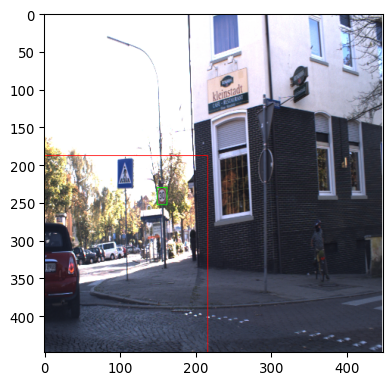

In [17]:
show_image_with_bbox(in_x / 255, in_y, predictions[0], 1, 14, 0)

In [ ]:
def show_image_with_bbox(batch_num, batch_idx):
    train_image, train_labels = training_sample[batch_num]
    train_image = train_image[batch_idx]
    train_labels = train_labels[batch_idx]

    train_true_obj = train_labels[..., 4]
    train_bbox_x_idx, train_bbox_y_idx = np.nonzero(train_true_obj)

    train_corner_bboxes = data_module.convert_cellbox_to_corner_bbox_numpy(
        train_labels[..., :4], np.array([7, 7], dtype="int32")
    )

    train_img_shape = np.shape(train_image)[:2]
    train_bbs = BoundingBoxesOnImage(
        [
            BoundingBox(
                x1=train_corner_bboxes[x, y, 0] * train_img_shape[1],
                y1=train_corner_bboxes[x, y, 1] * train_img_shape[0],
                x2=train_corner_bboxes[x, y, 2] * train_img_shape[1],
                y2=train_corner_bboxes[x, y, 3] * train_img_shape[0],
            )
            for x, y in zip(train_bbox_x_idx.tolist(), train_bbox_y_idx.tolist())
        ],
        shape=train_img_shape,
    )

    ia.imshow(train_bbs.draw_on_image(train_image), backend="matplotlib")

In [ ]:
show_image_with_bbox(0, 12)

In [ ]:
with CUSTOM_OBJECTS_PKL.open("rb") as f, plugin_dirs(["task-plugins"]):
    custom_objects = cloudpickle.load(f)

In [ ]:
object_detector = tf.keras.models.load_model(
    YOLO_MOBILENETV2, custom_objects=custom_objects
)

In [ ]:
y_pred = object_detector.predict(x)

In [ ]:
predictions = np.load(PREDICTIONS_NPY)

In [ ]:
predictions[0][5, 7, 1]

In [ ]:
testing_sample = list(testing_ds.as_numpy_iterator())

In [ ]:
testing_sample[0][0]

In [ ]:
def show_image_with_bbox(image, cellbox, i, j):
    corner_bboxes = data_module.convert_cellbox_to_corner_bbox_numpy(
        cellbox[..., :4], np.array([14, 14], dtype="int32")
    )

    img_shape = np.shape(image)[:2]
    bbs = BoundingBoxesOnImage(
        [
            BoundingBox(
                x1=corner_bboxes[i, j, 0] * img_shape[1],
                y1=corner_bboxes[i, j, 1] * img_shape[0],
                x2=corner_bboxes[i, j, 2] * img_shape[1],
                y2=corner_bboxes[i, j, 3] * img_shape[0],
            )
        ],
        shape=img_shape,
    )

    ia.imshow(bbs.draw_on_image(image), backend="matplotlib")


In [ ]:

def show_image_with_bbox(batch_num, batch_idx):
    train_image, train_labels = training_sample[batch_num]
    train_image = train_image[batch_idx]
    train_labels = train_labels[batch_idx]

    train_true_obj = train_labels[..., 4]
    train_bbox_x_idx, train_bbox_y_idx = np.nonzero(train_true_obj)

    train_corner_bboxes = data_module.convert_cellbox_to_corner_bbox_numpy(
        train_labels[..., :4], np.array([7, 7], dtype="int32")
    )

    train_img_shape = np.shape(train_image)[:2]
    train_bbs = BoundingBoxesOnImage(
        [
            BoundingBox(
                x1=train_corner_bboxes[x, y, 0] * train_img_shape[1],
                y1=train_corner_bboxes[x, y, 1] * train_img_shape[0],
                x2=train_corner_bboxes[x, y, 2] * train_img_shape[1],
                y2=train_corner_bboxes[x, y, 3] * train_img_shape[0],
            )
            for x, y in zip(train_bbox_x_idx.tolist(), train_bbox_y_idx.tolist())
        ],
        shape=train_img_shape,
    )

    ia.imshow(train_bbs.draw_on_image(train_image), backend="matplotlib")

In [ ]:
testing_sample[4][1][15][..., 7]

In [ ]:
predictions[4*16+15][4, 6, 1, 4]

In [ ]:
show_image_with_bbox(image=testing_sample[4][0][15].astype("uint8"), cellbox=predictions[4*16+15][..., 1, :], i=9, j=4)